<a target="_blank" href="https://colab.research.google.com/github/YuXia-SR/numpyro-example/blob/main/notebooks/snack_learn.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [ ]:
!pip install numpyro
!pip install arviz
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn
!pip install statsmodels

In [2]:
import jax.numpy as jnp
import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.infer import Predictive
from numpyro.distributions.transforms import SigmoidTransform
from jax import random
from numpyro.infer import MCMC, NUTS
import arviz as az

import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.metrics import mean_absolute_percentage_error

/Users/64313/miniconda3/envs/numpyro_example/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Overview

Probabilistic programming is a powerful tool for data scientists and statisticians that allows them to build complex models to make predictions based on uncertain or incomplete data. In this tutorial notebook, we will use the probabilistic programming library, Numpyro, to build a probabilistic model for predicting customer purchase probability in a retail marketing setup. The model will be based on historical data and will take into account several simple factors such as customer gender, product categories, and category visit times. Through this Snack & Learn session, we will work to implement the model, analyze the results, and discuss potential improvements. By the end of the notebook, you will have an understanding of probabilistic programming and the ability to use Numpyro to build probabilistic models for your own predictive analysis.

## Review the model
Following the same definition from the reference [1]
1. $C_u$ means consumer $u$ selects the category $c$
2. $B_{i, u}$ means consumer $u$ purchases product $i$
3. $Q_{i, u}=q$ means consumer $u$’s purchase quantity of $i$ is q

The joint probability of product demand is captured by a product of three conditional probabilities which represent the preferences in previous purchase stages.
$$
P(Q_{i, u}=q, B_{i, u}, C_u) = P(C_u) P(B_{i, u}| C_u) P(Q_{i, u}=q | B_{i, u}, C_u)
$$

Each purchase stage follows a similar modeling algorithm, thus we will focus on the category choice as an example to illustrate the method in this session.

# Prepare the synthetic dataset

In [3]:
# We're going to define our own dataset
# number of categories
n_category = 2
# number of customers
n_customer = 100
# number of observations in each combination of (customer, category)
# basically have an observation for each customer per month over 3 years
n_samples = 40

## Generate features and observations

Reminder: fold this section during the presentation

We're going to construct a synthetic on 100 customers' purchase decision of 2 categories. While we hold a naive assumptions of purchase probability based on the observations from daily life. These following numbers could not represent the actual purchase probability from person to person, but only serves to illustrate the model we're going to implement shortly.

In [4]:
def generate_global_features(n_category, n_customer, normal_dist = [(1.5, 0.1),(0.2, 0.1), (0.2, 0.1), (2.4, 0.1)]):
    # On the gender info, we shall use a contrast encoding vector to represent. [1] means male, [-1] means female.
    # odd index -> male, even index -> female
    gender_array = jnp.array([jnp.array([1]) if i % 2 == 0 else jnp.array([-1]) for i in range(n_customer)])
    # if the customer is a male
    # 1. his visit times of foundations is sampling from a normal distribution with mean 0.2 and std 0.1
    # 2. his visit times of razor is sampling from a normal distribution with mean 1.5 and std 0.1
    # if the customer is a female
    # 1. her visit times of foundations is sampling from a normal distribution with mean 2.4 and std 0.1
    # 2. her visit times of razor is sampling from a normal distribution with mean 0.2 and std 0.1
    category_visit_array = jnp.array([jnp.array([[np.random.normal(*normal_dist[0])], [np.random.normal(*normal_dist[1])]]) if i % 2 == 0 \
                                     else jnp.array([[np.random.normal(*normal_dist[2])], [np.random.normal(*normal_dist[3])]]) for i in range(n_customer)])

    global_feature = jnp.concatenate([gender_array.repeat(2, axis=0).reshape(n_customer, n_category, 1), category_visit_array], axis=-1)
    return global_feature
np.random.seed(0)
n_customer_test = 100
global_feature = generate_global_features(n_category, n_customer)
test_global_feature = generate_global_features(n_category, n_customer_test)

In [5]:
def convert_global_feature_to_df(global_feature, categories):
    n_customer, n_category, _ = global_feature.shape
    examine_data = pd.DataFrame(jnp.concatenate([global_feature[:, i, :] for i in range(len(categories))]), columns=['gender', 'visit_times'])
    examine_data.loc[:, 'customer_id'] = np.tile(np.arange(n_customer), n_category)
    examine_data.loc[:, 'category'] = np.repeat(categories, n_customer)
    examine_data = examine_data.loc[:, ['customer_id', 'category', 'gender', 'visit_times']].sort_values(by='customer_id', ignore_index=True)
    return examine_data
global_feature_df = convert_global_feature_to_df(global_feature, ['razor', 'foundation'])

In [6]:
def generate_category_feature(n_category, n_customer):
    return jnp.ones((n_customer, n_category, 1))
category_feature = generate_category_feature(n_category, n_customer)
test_category_feature = generate_category_feature(n_category, n_customer_test)

In [7]:
# we set the values of alpha and beta as following
alpha = jnp.array([-0.8, 0.5])
beta = jnp.array([jnp.array([np.random.normal(-0.8, 0.1)]) if i % 2 == 0 else jnp.array([np.random.normal(-2, 0.1)]) for i in range(n_customer)])

In [8]:
def compute_purchase_probability(global_feature, category_feature, global_coef, category_effect_coef):
    # global_feature: (n_customer, n_category, n_feature)
    # category_feature: (n_customer, n_category, n_feature)
    # global_coef: (n_feature)
    # category_effect_coef: (n_customer, n_feature)``
    # return: (n_customer, n_category)
    preference_score = jnp.matmul(global_feature, global_coef) + jnp.matmul(category_feature, jnp.expand_dims(category_effect_coef, axis=-1)).squeeze(axis=-1)
    purchase_prob = SigmoidTransform()(preference_score)
    return purchase_prob
def convert_purchase_prob_to_df(purchase_prob, categories, column_name='purchase_probability'):
    n_customer, n_category = purchase_prob.shape
    examine_data = pd.DataFrame(jnp.concatenate([purchase_prob[:, i] for i in range(len(categories))]), columns=[column_name])
    examine_data.loc[:, 'customer_id'] = np.tile(np.arange(n_customer), n_category)
    examine_data.loc[:, 'gender'] = np.tile([1, -1], n_customer)
    examine_data.loc[:, 'category'] = np.repeat(categories, n_customer)
    examine_data = examine_data.loc[:, ['customer_id', 'category', 'gender', column_name]].sort_values(by='customer_id', ignore_index=True)
    return examine_data
purchase_prob = compute_purchase_probability(global_feature, category_feature, alpha, beta)
sampling_y = dist.Bernoulli(probs=purchase_prob).sample(random.PRNGKey(0), sample_shape=(n_samples, ))
purchase_prob_df = convert_purchase_prob_to_df(purchase_prob, ['razor', 'foundation'])

In [9]:
purchase_prob_test = compute_purchase_probability(test_global_feature, test_category_feature, alpha, beta)
purchase_prob_test_df = convert_purchase_prob_to_df(purchase_prob_test, ['razor', 'foundation'])

## Inspect the feature table

We could define modeling goal to be learning the purchase behavior of female and male customers on two categories: razor and makeup foundations.

In [10]:
feature_table = global_feature_df.merge(purchase_prob_df)
feature_table.head()

,customer_id,category,gender,visit_times,purchase_probability
0,0,razor,1.0,1.676405,0.305411
1,0,foundation,1.0,0.240016,0.176556
2,1,razor,-1.0,0.297874,0.238186
3,1,foundation,-1.0,2.624089,0.500114
4,2,razor,1.0,1.686756,0.336271


In [13]:
def plot_distribution_from_df(data, target_column, ax):
    sns.violinplot(data, x='gender', y=target_column, hue='category', ax=ax)
    target_column = 'Visit times' if target_column == 'visit_times' else 'Purchase probability'
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Female', 'Male'])
    ax.set_xlabel('Gender')
    ax.set_ylabel(target_column)
    ax.set_title(f'{target_column} distribution across category')

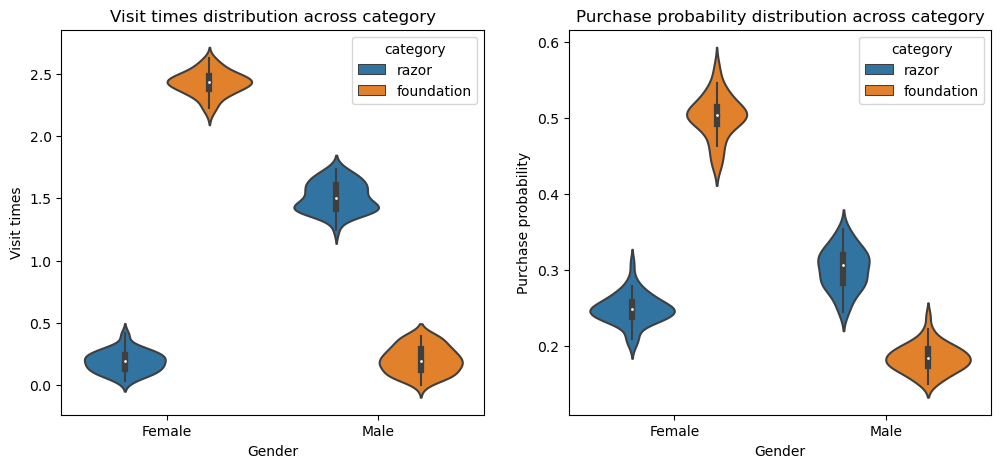

In [14]:
f, ax = plt.subplots(1, 2, figsize=(12, 5))
plot_distribution_from_df(feature_table, 'visit_times', ax[0])
plot_distribution_from_df(feature_table, 'purchase_probability', ax[1])

We could directly pass the purchase probability matrix to bernouli distribution and sample the category choice for each customer.

In [15]:
y_example = dist.Bernoulli(probs=purchase_prob).sample(random.PRNGKey(0))
purchase_decision_df = convert_purchase_prob_to_df(y_example, ['razor', 'foundation'], column_name='purchase_decision')
purchase_decision_df.head()

,customer_id,category,gender,purchase_decision
0,0,razor,1,1
1,0,foundation,1,0
2,1,razor,-1,0
3,1,foundation,-1,0
4,2,razor,1,0


# Model structure: Bayesian Hierarchical Linear Regression

For the category decision, we use a hierarchical linear model to approximate the purchase probability, and aim to estimate the coefficient $\alpha_1, \alpha_2, \beta_u$ defined below. For each customer $u$ and category $i$,

$$
\begin{align}
s_{ui} &= \alpha_1*Gender_{ui} + \alpha_2*VisitTimes_{ui} + \beta_u  \\
p_{ui} &= sigmoid(s_{ui}), \\
y_{ui} &\sim Bernouli(p_{ui})
\end{align}
$$

where we use the following notations
1. Gender is a global effect, and we'd like to see if customers with different genders have different purchase probability on categories. The corresponding coefficient $\alpha_1$ is shared across all customers and all categories.
2. Visit times is also a global effect, and the corresponding coefficient $\alpha_2$ remains the same as well across all customers and all categories.
3. The interception term is with subscription of customer $u$, aiming to capture category effects caused by different customers. Thus, $\beta$ will be in shape of (n_customer, )

<div style="text-align:center" heighr="400">

![causalDAG](../images/causalDAG.png)

</div>

We will model the first two terms together as the global effect and last term as the category effect. The preference score $s_{ui}$ will be the summation of these two effects. We assume all coefficient priors follow a normal distribution with different mean and standard deviation.
1. $\alpha_{1} \sim Normal(\mu_{\alpha_1}, \sigma^2_{\alpha_1})$, $\alpha_{2} \sim Normal(\mu_{\alpha_2}, \sigma^2_{\alpha_2})$
2. We need to initialize a coefficient matrix for the term of category effect, with shape of (n_customer, ). For each $\beta_u$, $\beta_u \sim Normal(\mu_{\beta_u}, \sigma^2_{\beta_u})$

<div style="text-align:center">

![modelDAG](../images/modelDAG.png)

</div>

## Implement the category choice model

In [16]:
def category_choice(
    X_global_effect_feature: jnp.DeviceArray,
    X_category_effect_feature: jnp.DeviceArray,
    y: jnp.DeviceArray=None
)-> jnp.DeviceArray:
    # read the shape of the input
    n_sample, n_customer, n_category, n_global_feature = X_global_effect_feature.shape
    n_category_feature = X_category_effect_feature.shape[-1]
    """
    Sample the alphas and compute global effect

    """
    # define the transformed distribution for alpha
    alpha_mu = numpyro.sample(
        "alpha_mu", 
        dist.Normal(loc=jnp.zeros(n_global_feature), 
        scale=jnp.ones(n_global_feature)))
    alpha_sigma = numpyro.sample(
        "alpha_sigma", 
        dist.HalfNormal(scale=jnp.ones(n_global_feature)))
    # generate coefficients for global effect
    alpha = numpyro.sample(
        'alpha',
        dist.Normal(alpha_mu, alpha_sigma),
    )
    # since we have two features for the global effects, alpha is in shape (2,)
    # compute effect components separately
    global_effect = jnp.matmul(X_global_effect_feature, alpha)

    """
    Sample the betas and compute category effect

    """
    # this plate restricts the row dimension of the customer coefficient matrix
    plate_customer = numpyro.plate("customer", n_customer, dim=-2)
    # this plate restricts the column dimension of the customer coefficient matrix
    plate_category_feature = numpyro.plate("category_feature", n_category_feature, dim=-1)
    with plate_customer, plate_category_feature:
        beta_mu = numpyro.sample(
            "beta_mu", 
            dist.Normal(loc=jnp.zeros((n_customer, n_category_feature)), 
            scale=jnp.ones((n_customer, n_category_feature))))
        beta_sigma = numpyro.sample(
            "beta_sigma", 
            dist.HalfNormal(scale=jnp.ones((n_customer, n_category_feature))))
        beta = numpyro.sample(
            'beta',
            dist.Normal(beta_mu, beta_sigma),
        )
        # adjust the shape of beta array
        beta = jnp.expand_dims(beta, axis=-1)
        # since we have only one feature for the category effects, beta is in shape (100, 1)
        # we extend a third dimension of beta to (100, 1, 1) such that it is compatible with the category feature
    category_effect = jnp.matmul(X_category_effect_feature, beta).squeeze(axis=-1)

    """
    Add effects term together and calculate the purchase probability

    """
    # this plate defines the first dimension of the output observation
    plate_sample_size = numpyro.plate("sample_size", n_sample, dim=-3)
    # this plate restricts the last dimension of the output observation
    plate_category = numpyro.plate("category", n_category, dim=-1)
    # generate the probability of purchase
    with plate_sample_size, plate_customer, plate_category:
        # compute the probability of purchase
        sigmoid = SigmoidTransform()
        purchase_prob = sigmoid(global_effect + category_effect)
        return numpyro.sample("category_choice", dist.Bernoulli(probs=purchase_prob), obs=y)

## Train the model using MCMC simulation

In [17]:
X_global_feature = jnp.expand_dims(global_feature, axis=0).repeat(n_samples, axis=0)
X_category_feature = jnp.expand_dims(category_feature, axis=0).repeat(n_samples, axis=0)
nuts_kernel = NUTS(category_choice)
mcmc = MCMC(nuts_kernel, num_warmup=100, num_samples=1000)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, X_global_feature, X_category_feature, sampling_y)

sample: 100%|██████████| 1100/1100 [04:03<00:00,  4.52it/s, 1023 steps of size 2.23e-03. acc. prob=0.98]


In [18]:
mcmc.print_summary()


                      mean       std    median      5.0%     95.0%     n_eff     r_hat
        alpha[0]     -0.18      0.12     -0.17     -0.37      0.03     25.08      1.11
        alpha[1]      0.46      0.03      0.46      0.42      0.50    193.43      1.01
     alpha_mu[0]     -0.14      0.49     -0.17     -0.95      0.65    241.08      1.00
     alpha_mu[1]      0.26      0.58      0.36     -0.66      1.22    233.81      1.01
  alpha_sigma[0]      0.64      0.53      0.52      0.00      1.40    335.38      1.00
  alpha_sigma[1]      0.71      0.54      0.60      0.00      1.48    353.26      1.00
       beta[0,0]     -1.36      0.30     -1.36     -1.82     -0.88    109.73      1.02
       beta[1,0]     -1.79      0.28     -1.79     -2.18     -1.26    133.52      1.02
       beta[2,0]     -1.69      0.31     -1.69     -2.19     -1.16    217.22      1.01
       beta[3,0]     -1.45      0.27     -1.45     -1.90     -1.00    107.47      1.03
       beta[4,0]     -1.58      0.29     -

## Check the model

### Inspecting the learned parameters
We will check the states recorded in the MCMC object to see if all coefficients are converged. We will also use the Arviz package to visualize the trace.

In [19]:
# check if MCMC is converging
assert ~ mcmc._states['diverging'].all()

array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>]], dtype=object)

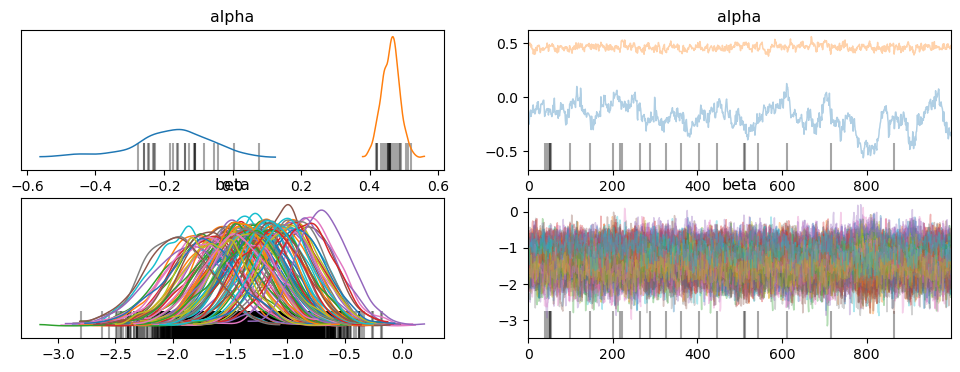

In [20]:
data = az.from_numpyro(mcmc)
az.plot_trace(data, var_names=['alpha', 'beta'])

Looks like the model is able to learn alpha and beta for each customer.

## Use the model for inference

## Extract learnt coefficient
If the model coefficients all converge, we could extract the learnt value from the object that recorded the trace of MCMC, and compute the mean of each coefficient as the learnt value. In this way, we obtain a full control of the linear model and are able to compute the purchase probability ourselves.

In [21]:
# extract the learnt parameters
learnt_alpha = mcmc._states['z']['alpha'].mean(axis=1).reshape(2, )
learnt_beta = mcmc._states['z']['beta'].mean(axis=1).reshape(n_customer, 1)

In [22]:
# Use the learnt parameter to compute the purchase probability
learnt_prob = compute_purchase_probability(test_global_feature, test_category_feature, learnt_alpha, learnt_beta)
learnt_prob_df = convert_purchase_prob_to_df(learnt_prob, ['razor', 'foundation'], column_name='purchase_probability')
learnt_prob_df.head()

,customer_id,category,gender,purchase_probability
0,0,razor,1,0.296299
1,0,foundation,1,0.188633
2,1,razor,-1,0.187658
3,1,foundation,-1,0.384487
4,2,razor,1,0.241260


We put the dataframe of true purchase probability side-by-side with the dataframe of predicted purchase probability

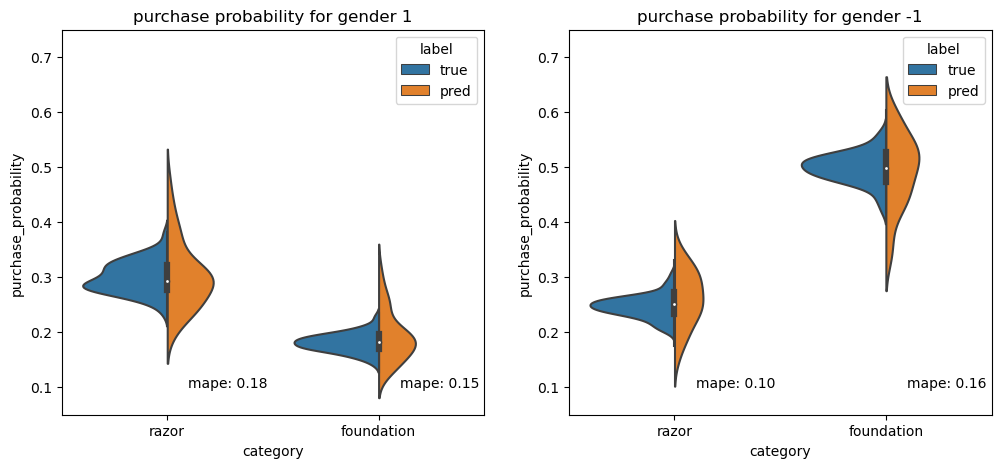

In [23]:
prob_comparison_df = pd.concat([purchase_prob_test_df, learnt_prob_df])
prob_comparison_df.loc[:, 'label'] = np.repeat(['true', 'pred'], n_customer * 2)

def plot_prob_comparison(df: pd.DataFrame, group_column:str, filter: tuple, ax):
    data = df[df[filter[0]]==filter[1]]
    mape = data.groupby(group_column).apply(lambda x: mean_absolute_percentage_error(x[x.label == 'true'].purchase_probability, x[x.label == 'pred'].purchase_probability))
    sns.violinplot(x=group_column, y='purchase_probability', hue='label', data=data, split=True, ax=ax)
    ax.text(0.1, 0.1, s='mape: {:.2f}'.format(mape.iloc[0]), fontsize=10)
    ax.text(1.1, 0.1, s='mape: {:.2f}'.format(mape.iloc[1]), fontsize=10)
    ax.set_title('purchase probability for {} {}'.format(*filter))
    ax.set_ylim(0.05, 0.75)

f, ax = plt.subplots(1, 2, figsize=(12, 5))
plot_prob_comparison(prob_comparison_df, 'category', ('gender', 1), ax[0])
plot_prob_comparison(prob_comparison_df, 'category', ('gender', -1), ax[1])

## Use posterior samples

We could also leverage the samples from MCMC simulation for prediction or even creating large amount of synthetic data.

In [24]:
# get posterior samples
X_test_global_feature = jnp.expand_dims(test_global_feature, axis=0).repeat(n_samples, axis=0)
X_test_category_feature = jnp.expand_dims(test_category_feature, axis=0).repeat(n_samples, axis=0)

posterior_samples = mcmc.get_samples()
predictive = Predictive(category_choice, posterior_samples)
prediction = predictive(rng_key, X_test_global_feature, X_test_category_feature)["category_choice"]
# compute the mean of purchase choice for each customer to approximate the purchase probability
prob_mean = prediction.mean(axis=[0,1])
prob_mean_df = convert_purchase_prob_to_df(prob_mean, ['razor', 'foundation'], column_name='purchase_probability')

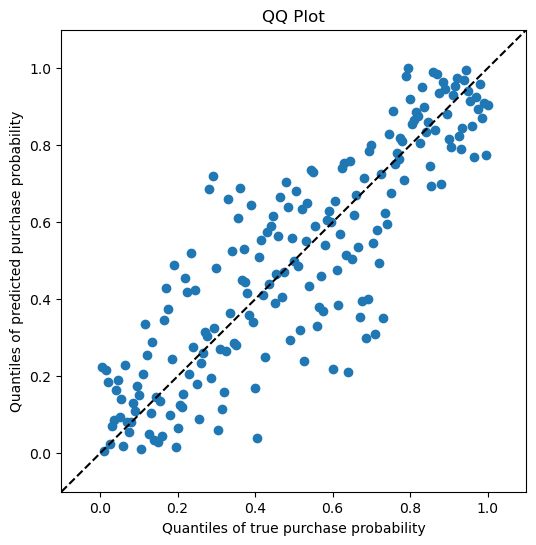

In [25]:
def draw_qq_plot(true, pred, axis_range=(-0.1, 1.1)):

    # Compute the quantiles for x and y
    x_quantiles = sm.distributions.ECDF(true)(true)
    y_quantiles = sm.distributions.ECDF(pred)(pred)

    # Create a QQ plot
    _, ax = plt.subplots(figsize=(6,6))
    ax.scatter(x_quantiles, y_quantiles)
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls='--', c='k')
    plt.xlim(*axis_range)
    plt.ylim(*axis_range)
    # Set plot title and labels
    plt.title('QQ Plot')
    plt.xlabel('Quantiles of true purchase probability')
    plt.ylabel('Quantiles of predicted purchase probability')
draw_qq_plot(purchase_prob_df.purchase_probability, prob_mean_df.purchase_probability)

# Wrap-up

Hope this notebook provides a starting point for you to explore Numpyro and probabilistic programming. We find the following pages useful to quickly get a taste of Numpyro:

1. "Numpyro distributions". [webpage](https://num.pyro.ai/en/stable/distributions.html)
2. "Bayesian Regression Using Numpyro". [notebook](https://num.pyro.ai/en/stable/tutorials/bayesian_regression.html)
3. Charlos et.al. "Bayesian Hierarchical Linear Regression". [notebook](https://num.pyro.ai/en/stable/tutorials/bayesian_hierarchical_linear_regression.html)

For the research model we will test with retail dataset and the application in the retail environment simulation, please stay tuned with the update in the [Retmar](https://github.com/Bain/retmar) repository


# References
1. Mengting et. al. 2017. “Modeling Consumer Preferences and Price Sensitivities from Large-Scale Grocery Shopping Transaction Logs”. Proceedings of the 26th International Conference on World Wide Web​
2. "Numpyro documentation". Uber Technologies, Inc. https://num.pyro.ai/en/stable/index.html